In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import sys
sys.path.append(str(Path.cwd() / "_scripts"))

In [43]:
import seaborn as sns
import seaborn.objects as so
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import re

from helpers.variable_interfaces import all_variables as vars
from setup.materials_setup import retrieve_cases
# from setup.data_wrangle2 import *
from analysis.helpers import map_zone_names, extract_times
from analysis.plot_helpers import set_axis_ticks
from analysis.dataframes2 import *
# from analysis.volumes import *
from helpers.ep_helpers import WallNormal

sns.set_style("darkgrid")

In [4]:
cases = retrieve_cases()

In [5]:
medium_cases = [i for i in cases if "Medium" in i.case_name]
[case] = [i for i in medium_cases if "red" in i.case_name]
case

CaseData(case_name='Medium_case_red_b1', idf=<geomeppy.idf.IDF object at 0x152510130>, sql=Energy SQLiteResult: /Users/julietnwagwuume-ezeoke/_UILCode/gqe-phd/geomeppy/cases/material_exp/Medium_case_red_b1/results/eplusout.sql, path_to_input=PosixPath('/Users/julietnwagwuume-ezeoke/_UILCode/gqe-phd/svg2plan/outputs2/case_red_b1'), path_to_output=PosixPath('/Users/julietnwagwuume-ezeoke/_UILCode/gqe-phd/geomeppy/cases/material_exp/Medium_case_red_b1'))

In [132]:
df_node = get_external_node_df(case)
df_ext = df_node.filter(pl.col("space_names").str.contains("Ext"))
d = df_ext.select("space_names", "AFN Node Wind Pressure [Pa]", "datetimes")
df_ext_wide = d.pivot(on ="space_names", index="datetimes", values="AFN Node Wind Pressure [Pa]")
df_ext_wide.head()

datetimes,ExtNode 1,ExtNode 2,ExtNode 3,ExtNode 4,ExtNode 5,ExtNode 6,ExtNode 7,ExtNode 8,ExtNode 9
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2017-07-01 00:00:00,-0.201207,0.056386,-0.201207,-0.201207,-0.201207,-0.139499,-0.139499,0.056386,0.130645
2017-07-01 00:15:00,-0.19519,0.034077,-0.19519,-0.19519,-0.19519,-0.111791,-0.111791,0.034077,0.134441
2017-07-01 00:30:00,-0.164612,0.006479,-0.164612,-0.164612,-0.164612,-0.099015,-0.099015,0.006479,0.126161
2017-07-01 00:45:00,-0.137344,-0.015615,-0.137344,-0.137344,-0.137344,-0.087086,-0.087086,-0.015615,0.117332
2017-07-01 01:00:00,-0.126187,-0.014346,-0.126187,-0.126187,-0.126187,-0.080012,-0.080012,-0.014346,0.107801


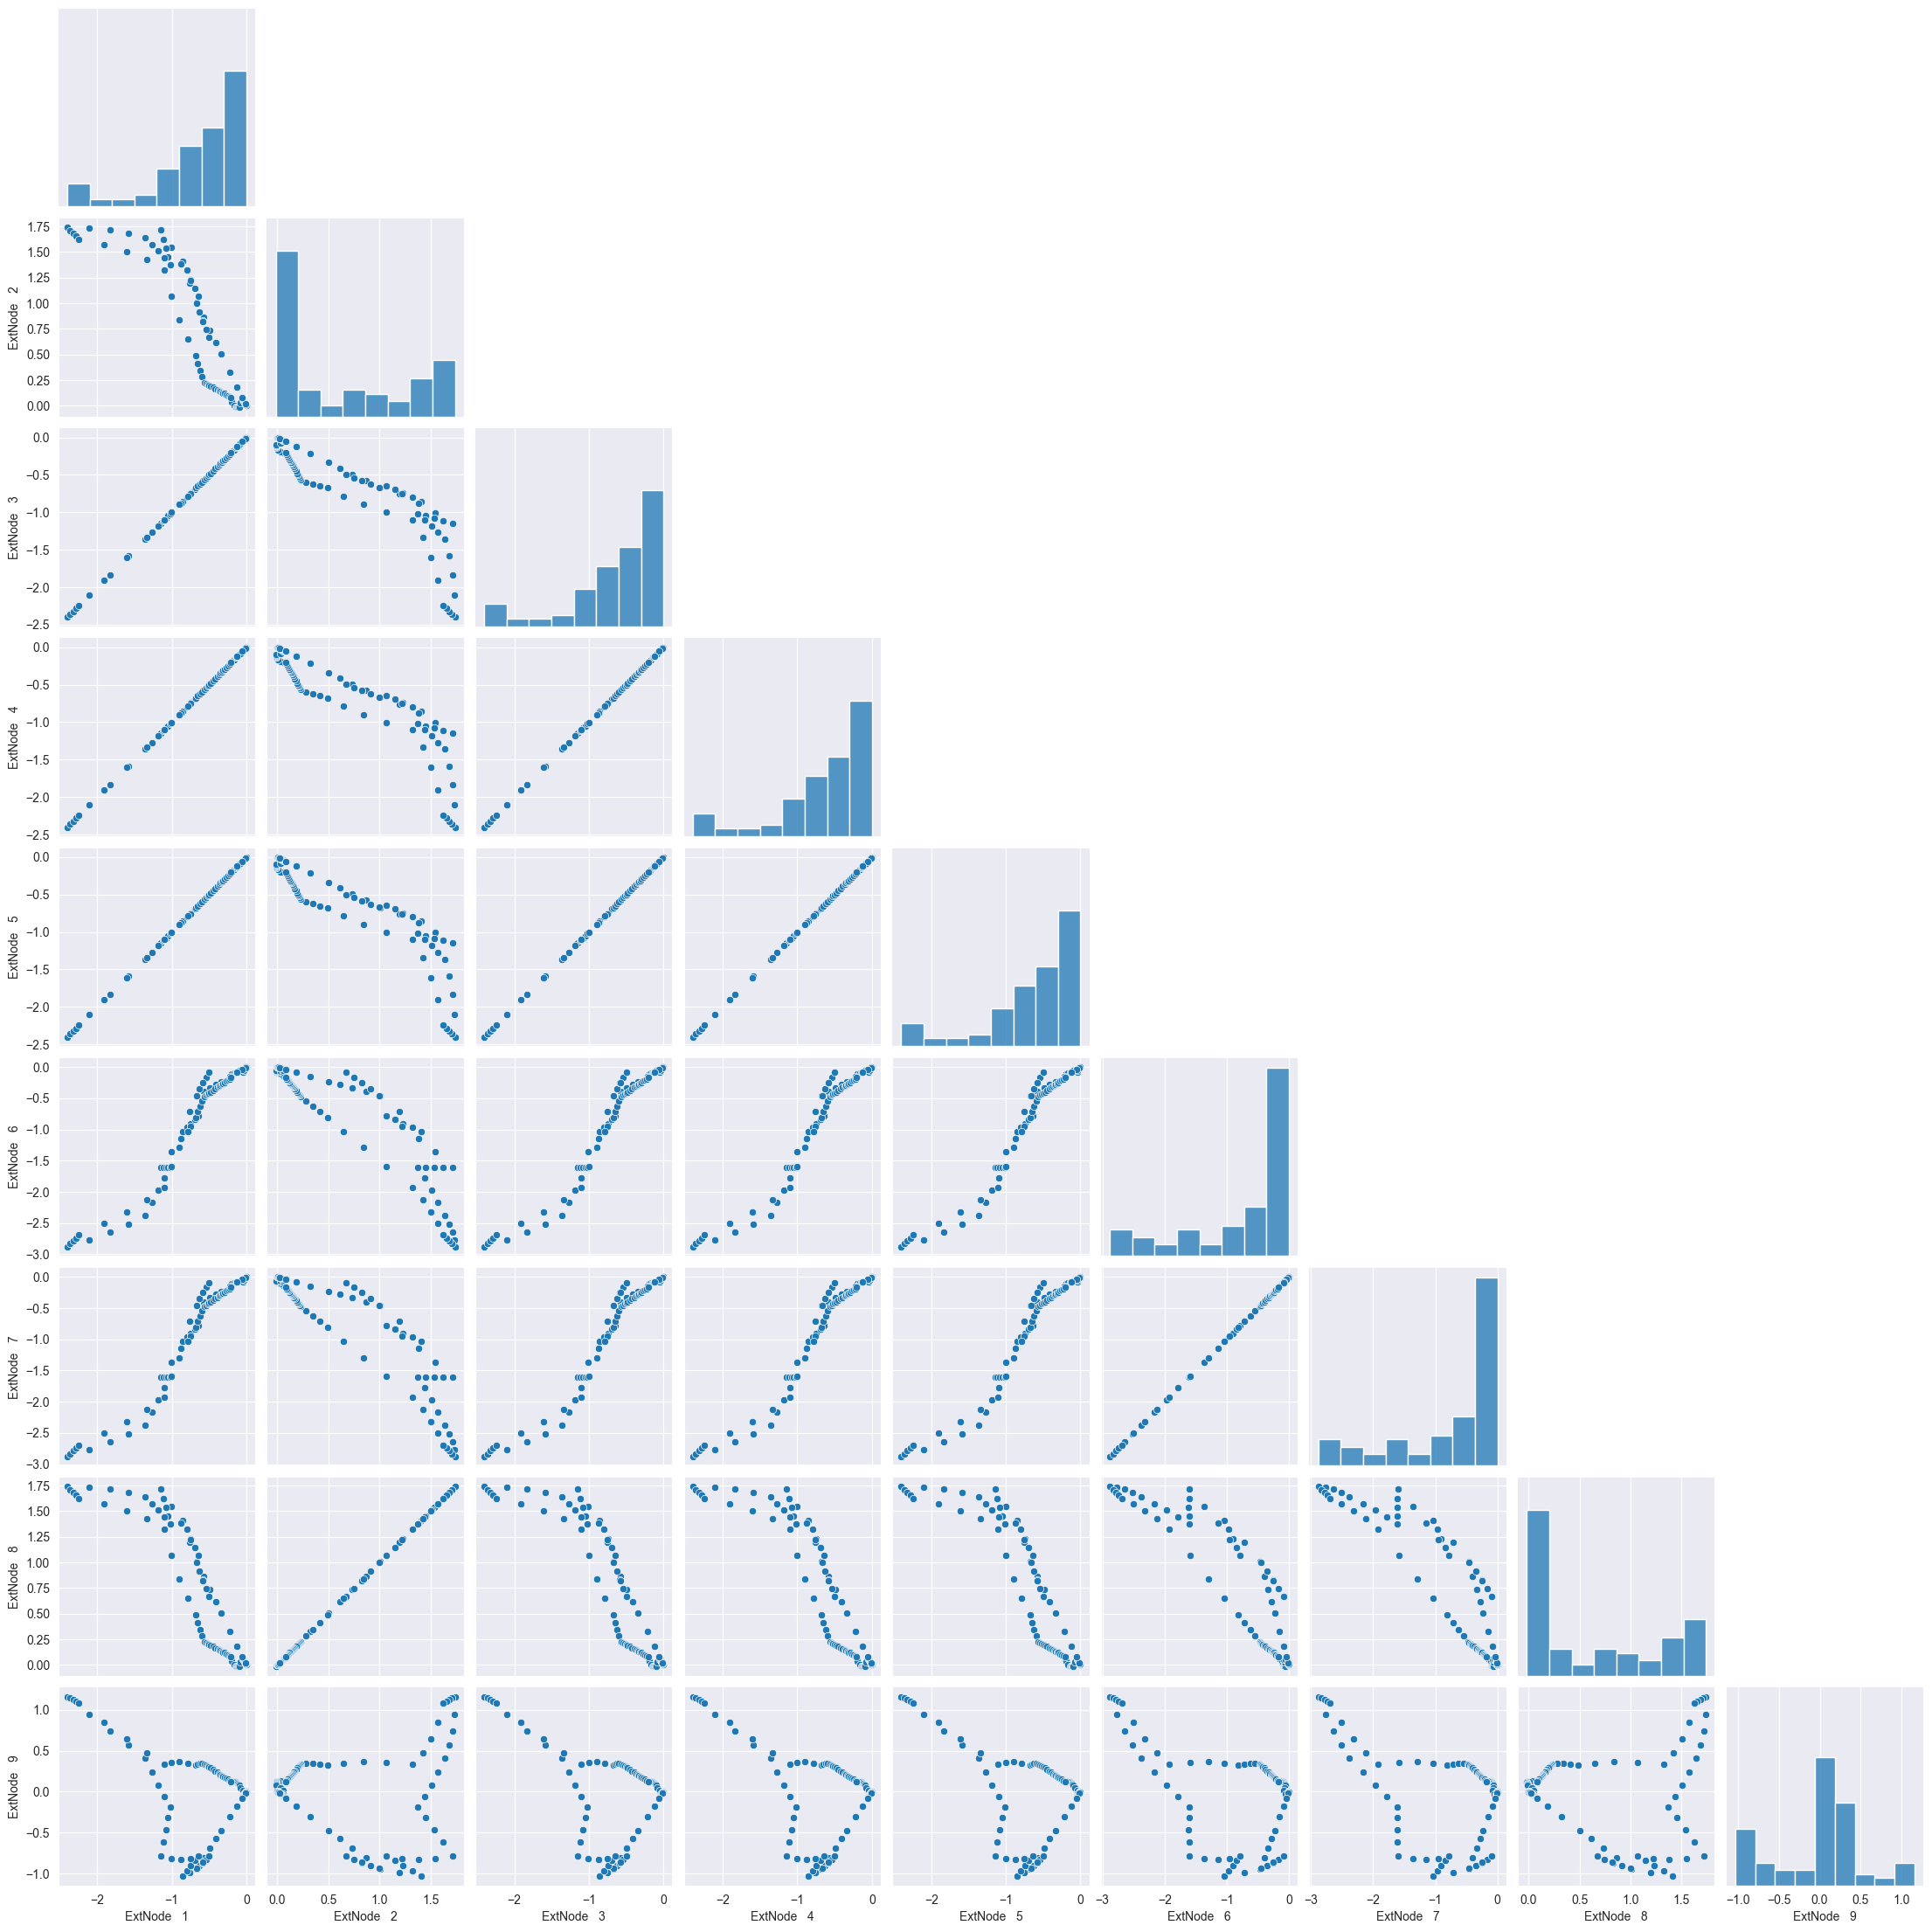

In [138]:
sns.pairplot(df_ext_wide.to_pandas(), corner=True)

In [119]:
df_linkage = create_linkage_df(case)
# find all the linkages to outside.. 
directions = [i.name for i in WallNormal]
df_windows = pl.concat([df_linkage.filter(pl.col("directed_pairs").list.contains(i)) for i in directions])
df_windows.head()

case_names,space_names,datetimes,AFN Linkage Node 1 to Node 2 Volume Flow Rate [m3/s],AFN Linkage Node 2 to Node 1 Volume Flow Rate [m3/s],net_linkage,room_pairs,directed_pairs
str,str,datetime[μs],f64,f64,f64,object,list[str]
"""Medium_case_red_b1""","""BLOCK 01 STOREY 0 WALL 0002 WI…",2017-07-01 00:00:00,0.0,0.4941,0.0,"['1-bedroom_1', 'NORTH']","[""1-bedroom_1"", ""NORTH""]"
"""Medium_case_red_b1""","""BLOCK 01 STOREY 0 WALL 0002 WI…",2017-07-01 00:15:00,0.0,0.45023,0.0,"['1-bedroom_1', 'NORTH']","[""1-bedroom_1"", ""NORTH""]"
"""Medium_case_red_b1""","""BLOCK 01 STOREY 0 WALL 0002 WI…",2017-07-01 00:30:00,0.0,0.381515,0.0,"['1-bedroom_1', 'NORTH']","[""1-bedroom_1"", ""NORTH""]"
"""Medium_case_red_b1""","""BLOCK 01 STOREY 0 WALL 0002 WI…",2017-07-01 00:45:00,0.00271,0.302765,0.00271,"['1-bedroom_1', 'NORTH']","[""1-bedroom_1"", ""NORTH""]"
"""Medium_case_red_b1""","""BLOCK 01 STOREY 0 WALL 0002 WI…",2017-07-01 01:00:00,0.0,0.291578,0.0,"['1-bedroom_1', 'NORTH']","[""1-bedroom_1"", ""NORTH""]"


In [120]:
# 2 -> 1 == outside to inside 
d2 = df_windows.select("datetimes", "AFN Linkage Node 2 to Node 1 Volume Flow Rate [m3/s]", "space_names")
df_windows_wide = d2.pivot(on ="space_names", index="datetimes", values="AFN Linkage Node 2 to Node 1 Volume Flow Rate [m3/s]")

df_windows_wide.head()

datetimes,BLOCK 01 STOREY 0 WALL 0002 WINDOW,BLOCK 02 STOREY 0 WALL 0002 WINDOW,BLOCK 03 STOREY 0 WALL 0001 WINDOW,BLOCK 02 STOREY 0 WALL 0001 WINDOW,BLOCK 04 STOREY 0 WALL 0004 WINDOW,BLOCK 09 STOREY 0 WALL 0004 WINDOW,BLOCK 03 STOREY 0 WALL 0004 WINDOW,BLOCK 05 STOREY 0 WALL 0004 WINDOW,BLOCK 09 STOREY 0 WALL 0003 WINDOW
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2017-07-01 00:00:00,0.4941,0.557066,0.130367,0.0,0.011107,0.0,0.001433,0.0,0.664705
2017-07-01 00:15:00,0.45023,0.498349,0.183441,0.000063,0.004137,0.0,0.0,0.0,0.654626
2017-07-01 00:30:00,0.381515,0.420504,0.158788,0.010214,0.018018,0.0,0.003238,0.0,0.624263
2017-07-01 00:45:00,0.302765,0.334662,0.144803,0.055282,0.045914,0.0,0.034797,0.012526,0.580651
2017-07-01 01:00:00,0.291578,0.325118,0.134522,0.036516,0.033021,0.0,0.020152,0.002616,0.566806


In [133]:
df_join = df_windows_wide.join(df_ext_wide, on=["datetimes"])
df_join.head()

datetimes,BLOCK 01 STOREY 0 WALL 0002 WINDOW,BLOCK 02 STOREY 0 WALL 0002 WINDOW,BLOCK 03 STOREY 0 WALL 0001 WINDOW,BLOCK 02 STOREY 0 WALL 0001 WINDOW,BLOCK 04 STOREY 0 WALL 0004 WINDOW,BLOCK 09 STOREY 0 WALL 0004 WINDOW,BLOCK 03 STOREY 0 WALL 0004 WINDOW,BLOCK 05 STOREY 0 WALL 0004 WINDOW,BLOCK 09 STOREY 0 WALL 0003 WINDOW,ExtNode 1,ExtNode 2,ExtNode 3,ExtNode 4,ExtNode 5,ExtNode 6,ExtNode 7,ExtNode 8,ExtNode 9
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2017-07-01 00:00:00,0.4941,0.557066,0.130367,0.0,0.011107,0.0,0.001433,0.0,0.664705,-0.201207,0.056386,-0.201207,-0.201207,-0.201207,-0.139499,-0.139499,0.056386,0.130645
2017-07-01 00:15:00,0.45023,0.498349,0.183441,0.000063,0.004137,0.0,0.0,0.0,0.654626,-0.19519,0.034077,-0.19519,-0.19519,-0.19519,-0.111791,-0.111791,0.034077,0.134441
2017-07-01 00:30:00,0.381515,0.420504,0.158788,0.010214,0.018018,0.0,0.003238,0.0,0.624263,-0.164612,0.006479,-0.164612,-0.164612,-0.164612,-0.099015,-0.099015,0.006479,0.126161
2017-07-01 00:45:00,0.302765,0.334662,0.144803,0.055282,0.045914,0.0,0.034797,0.012526,0.580651,-0.137344,-0.015615,-0.137344,-0.137344,-0.137344,-0.087086,-0.087086,-0.015615,0.117332
2017-07-01 01:00:00,0.291578,0.325118,0.134522,0.036516,0.033021,0.0,0.020152,0.002616,0.566806,-0.126187,-0.014346,-0.126187,-0.126187,-0.126187,-0.080012,-0.080012,-0.014346,0.107801


In [134]:
block_cols = [i for i in df_join.columns if "BLOCK" in i]
ext_cols = [i for i in df_join.columns if "Ext" in i]


In [136]:
pdf_join = df_join.to_pandas()
pdf_join.head()

,datetimes,BLOCK 01 STOREY 0 WALL 0002 WINDOW,BLOCK 02 STOREY 0 WALL 0002 WINDOW,BLOCK 03 STOREY 0 WALL 0001 WINDOW,BLOCK 02 STOREY 0 WALL 0001 WINDOW,BLOCK 04 STOREY 0 WALL 0004 WINDOW,BLOCK 09 STOREY 0 WALL 0004 WINDOW,BLOCK 03 STOREY 0 WALL 0004 WINDOW,BLOCK 05 STOREY 0 WALL 0004 WINDOW,BLOCK 09 STOREY 0 WALL 0003 WINDOW,ExtNode 1,ExtNode 2,ExtNode 3,ExtNode 4,ExtNode 5,ExtNode 6,ExtNode 7,ExtNode 8,ExtNode 9
0,2017-07-01 00:00:00,0.494100,0.557066,0.130367,0.000000,0.011107,0.0,0.001433,0.000000,0.664705,-0.201207,0.056386,-0.201207,-0.201207,-0.201207,-0.139499,-0.139499,0.056386,0.130645
1,2017-07-01 00:15:00,0.450230,0.498349,0.183441,0.000063,0.004137,0.0,0.000000,0.000000,0.654626,-0.195190,0.034077,-0.195190,-0.195190,-0.195190,-0.111791,-0.111791,0.034077,0.134441
2,2017-07-01 00:30:00,0.381515,0.420504,0.158788,0.010214,0.018018,0.0,0.003238,0.000000,0.624263,-0.164612,0.006479,-0.164612,-0.164612,-0.164612,-0.099015,-0.099015,0.006479,0.126161
3,2017-07-01 00:45:00,0.302765,0.334662,0.144803,0.055282,0.045914,0.0,0.034797,0.012526,0.580651,-0.137344,-0.015615,-0.137344,-0.137344,-0.137344,-0.087086,-0.087086,-0.015615,0.117332
4,2017-07-01 01:00:00,0.291578,0.325118,0.134522,0.036516,0.033021,0.0,0.020152,0.002616,0.566806,-0.126187,-0.014346,-0.126187,-0.126187,-0.126187,-0.080012,-0.080012,-0.014346,0.107801


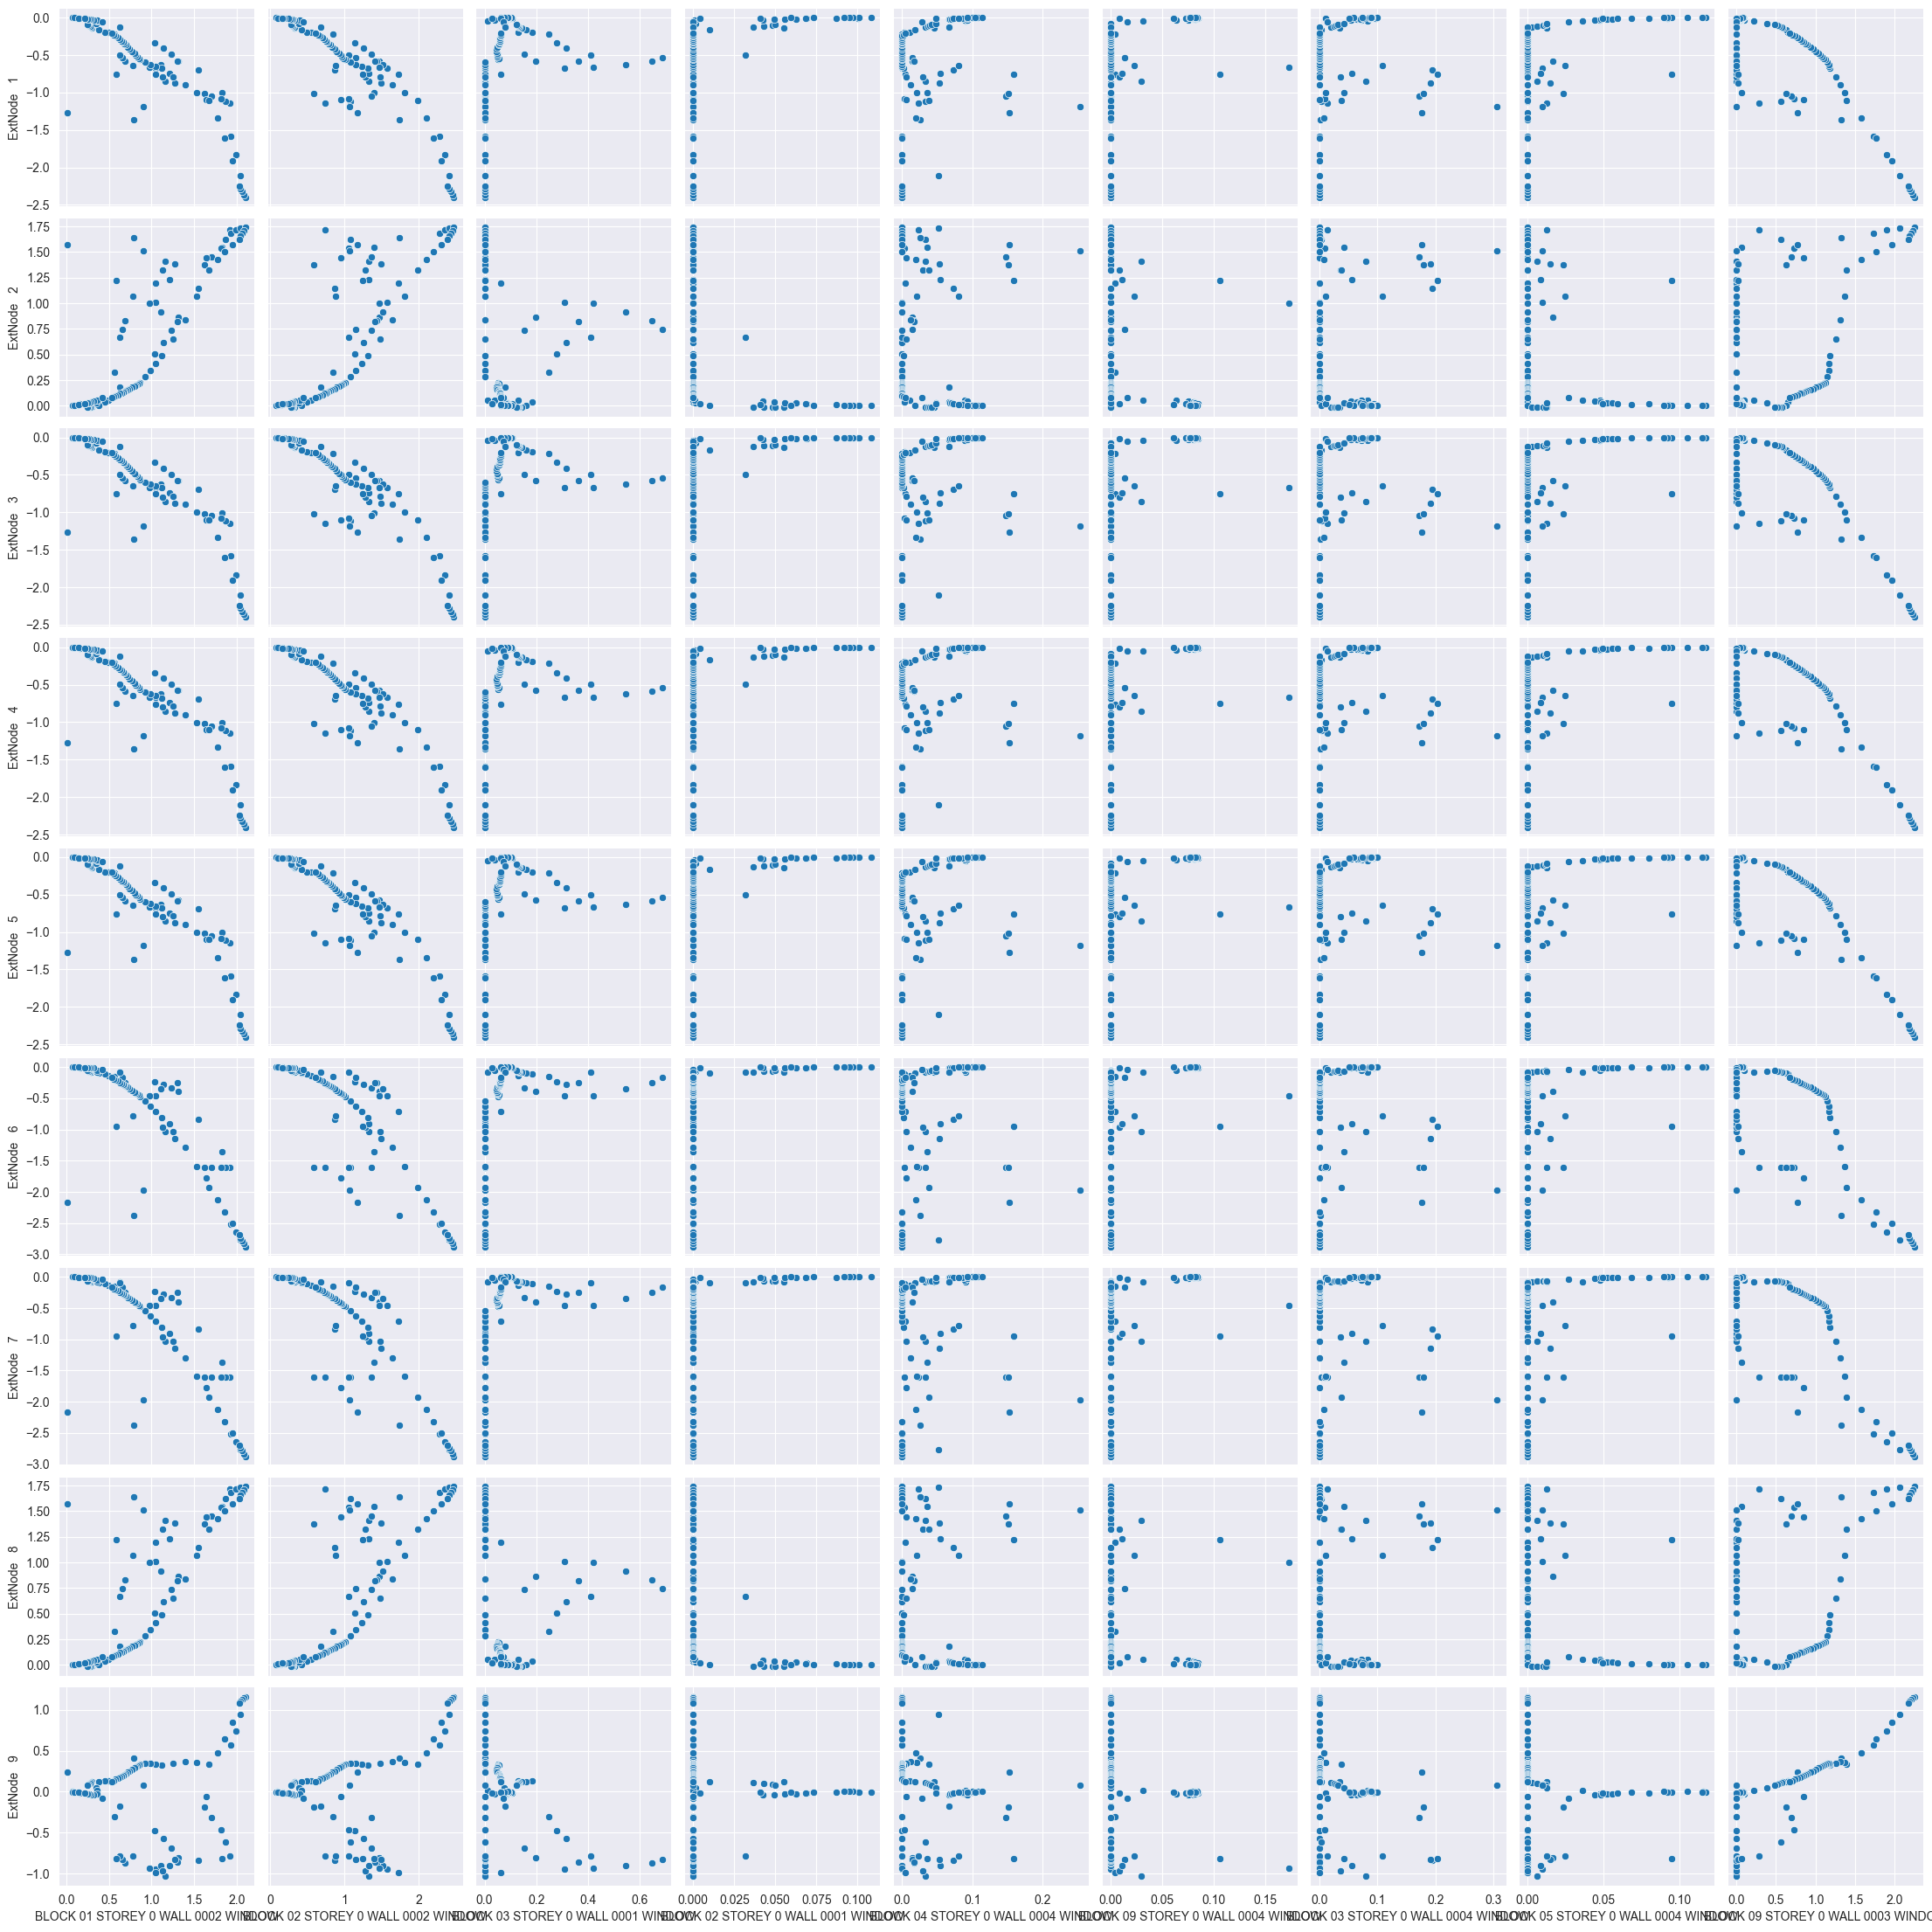

In [135]:
sns.pairplot(pdf_join, x_vars=block_cols, y_vars=ext_cols)

In [ ]:
# sort based on order of appearance in idf?